# Load Forecasting
### 1. Data manipulation

Start by merging the load data and covariate data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

In [2]:
# Read processed load data
base_dir = os.getcwd()
load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
load_data = pd.read_csv(load_file_path)
#print(load_data.head())

# Read processed temperature data
temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
avg_temperature_data = pd.read_csv(temperature_file_path)
#print(avg_temperature_data.head())

# Read processed humidity data
humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
avg_humidity_data = pd.read_csv(humidity_file_path)
#print(avg_humidity_data.head())

# Read processed solar irradiation data
solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
avg_solar_data = pd.read_csv(solar_file_path)
#print(avg_solar_data.head())

load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
data = load_data.copy()
data['temperature'] = avg_temperature_data['weighted_avg'].values
data['humidity'] = avg_humidity_data['weighted_avg'].values
data['solar'] = avg_solar_data['weighted_avg'].values


In this section we implement the machine learning models. We start with our benchmark model which will later be used to compare the reaults of our 'advanced' models.

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


component            Actual Total Load [MW] - BZN|SE4
Timestamp                                            
2025-01-01 00:00:00                            2100.0
2025-01-01 01:00:00                            2089.0
2025-01-01 02:00:00                            2017.0
2025-01-01 03:00:00                            2050.0
2025-01-01 04:00:00                            2134.0
...                                               ...
2025-02-07 07:00:00                            2624.0
2025-02-07 08:00:00                            2636.0
2025-02-07 09:00:00                            2727.0
2025-02-07 10:00:00                            2835.0
2025-02-07 11:00:00                            2849.0

[900 rows x 1 columns]


<Axes: xlabel='Timestamp'>

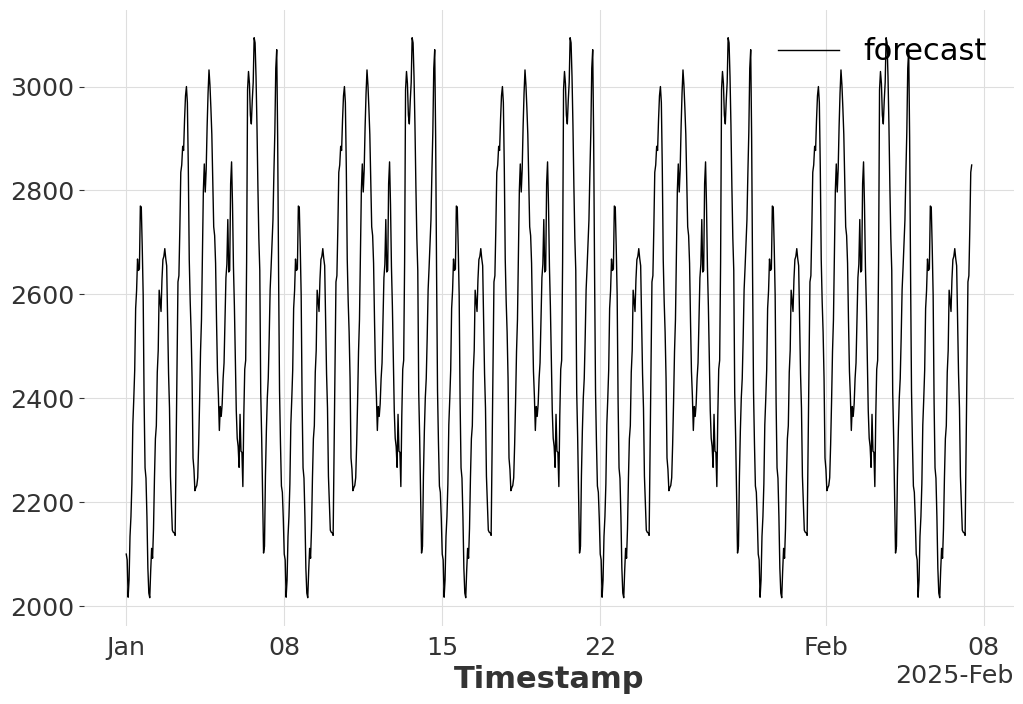

In [3]:
from darts.models import NaiveSeasonal
from darts import TimeSeries

#filepath = os.path.join("LoadData", "total_loadUTC_data.csv")
#data = pd.read_csv(filepath)
#data = pd.read_csv(filepath)

# Extract start timestamp (from "01.01.2015 00:00 - 01.01.2015 01:00")
load_data['Timestamp'] = pd.to_datetime(
    load_data['Time (UTC)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
)

# Set timestamp as index
load_data.set_index('Timestamp', inplace=True)

# Select one target column only (univariate series)
forecast_data = load_data['Actual Total Load [MW] - BZN|SE4']

# Create TimeSeries object
series = TimeSeries.from_series(forecast_data)

model = NaiveSeasonal(K=168) # weekly seasonality
model.fit(series)
pred = model.predict(900) # change this to number of hours to be plotted
print(pred.pd_dataframe())
pred.plot(label="forecast", lw=1)

Including holidays as covariate

In [4]:
import holidays

years = np.arange(2015, 2025)

raw_holidays = []
for date, name in sorted(holidays.Sweden(years=years).items()):
    if not name == "Söndag":
        raw_holidays.append(date)
        #print(date, name)
holiday_dates = set(raw_holidays)
print(holiday_dates)

{datetime.date(2015, 6, 6), datetime.date(2019, 1, 6), datetime.date(2022, 11, 5), datetime.date(2019, 12, 25), datetime.date(2015, 6, 19), datetime.date(2017, 1, 6), datetime.date(2015, 1, 6), datetime.date(2019, 4, 21), datetime.date(2021, 5, 13), datetime.date(2024, 1, 1), datetime.date(2022, 4, 15), datetime.date(2019, 12, 26), datetime.date(2023, 4, 7), datetime.date(2017, 4, 17), datetime.date(2018, 5, 1), datetime.date(2020, 4, 13), datetime.date(2023, 12, 24), datetime.date(2024, 12, 31), datetime.date(2020, 1, 1), datetime.date(2015, 12, 31), datetime.date(2018, 12, 26), datetime.date(2017, 12, 24), datetime.date(2020, 1, 6), datetime.date(2022, 5, 26), datetime.date(2015, 5, 1), datetime.date(2022, 12, 25), datetime.date(2023, 6, 23), datetime.date(2020, 6, 19), datetime.date(2022, 6, 5), datetime.date(2023, 12, 25), datetime.date(2020, 4, 10), datetime.date(2017, 12, 26), datetime.date(2019, 12, 31), datetime.date(2020, 5, 31), datetime.date(2021, 12, 26), datetime.date(2015

Now merge all load and covariate data into one data frame

In [5]:
import datetime

## Alternative 1: minimal data frame, possibly bad for plotting
#data['is_holiday'] = data['Time (UTC)'].apply(
#    lambda x: datetime.datetime.strptime(x.split(' - ')[0], '%d.%m.%Y %H:%M').date() in holiday_dates
#).astype(int)

## Alternative 2: add start_time and end_time for plotting purposes
# Split time range into start and end
#data[['start_time', 'end_time']] = data['Time (UTC)'].str.split(' - ', expand=True)

# Convert to datetime
#data['start_time'] = pd.to_datetime(data['start_time'], format='%d.%m.%Y %H:%M')
#data['end_time'] = pd.to_datetime(data['end_time'], format='%d.%m.%Y %H:%M')
#data['is_holiday'] = data['start_time'].dt.date.isin(holiday_dates).astype(int)

# Alternative 3: simple timestamp instead of time range
data['Time (UTC)'] = pd.to_datetime(data['Time (UTC)'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
data = data.set_index('Time (UTC)')
#print(data)
#data['is_holiday'] = data['Time (UTC)'].dt.date.isin(holiday_dates).astype(int)
data['is_holiday'] = pd.Series(data.index.date, index=data.index).isin(holiday_dates).astype(int)
print(data.head())

                     Actual Total Load [MW] - BZN|SE4  temperature   humidity  \
Time (UTC)                                                                      
2015-01-01 00:00:00                            2267.0     4.451320  86.611602   
2015-01-01 01:00:00                            2281.0     4.217264  85.613668   
2015-01-01 02:00:00                            2313.0     4.302403  85.022984   
2015-01-01 03:00:00                            2372.0     4.207889  86.857752   
2015-01-01 04:00:00                            2424.0     4.572334  85.142699   

                     solar  is_holiday  
Time (UTC)                              
2015-01-01 00:00:00    0.0           1  
2015-01-01 01:00:00    0.0           1  
2015-01-01 02:00:00    0.0           1  
2015-01-01 03:00:00    0.0           1  
2015-01-01 04:00:00    0.0           1  


Random forest model 

In [9]:
from darts.models import RandomForest
from darts.metrics import mape
# Read CSV and parse 'Time (UTC)' as datetime while loading
data = pd.read_csv('data.csv', parse_dates=['Time (UTC)'])

# Set 'Time (UTC)' as index
data = data.set_index('Time (UTC)')

# Split data
split_dates = ['2020-01-01', '2022-01-01', '2024-01-01']  # Adjust according to your dataset

# Split train, validation, and test sets
train = data[:split_dates[0]]  # from start to 2020-01-01
valid = data[split_dates[0]:split_dates[1]]  # from 2020-01-01 to 2022-01-01
test = data[split_dates[1]:split_dates[2]]  # from 2022-01-01 to 2024-01-01

# Convert to Darts TimeSeries objects with explicit frequency 'H' (hourly)
target_column = 'Actual Total Load [MW] - BZN|SE4'

train_series = TimeSeries.from_dataframe(train, value_cols=target_column, freq='h')
valid_series = TimeSeries.from_dataframe(valid, value_cols=target_column, freq='h')
test_series = TimeSeries.from_dataframe(test, value_cols=target_column, freq='h')

# Prepare covariates
feature_columns = ['temperature', 'humidity', 'solar', 'is_holiday', 'hour', 'dayofweek', 'is_weekend']
train_covariates = TimeSeries.from_dataframe(train, value_cols=feature_columns, freq='h')
valid_covariates = TimeSeries.from_dataframe(valid, value_cols=feature_columns, freq='h')
test_covariates = TimeSeries.from_dataframe(test, value_cols=feature_columns, freq='h')

# n_jobs -1, squared error
# Create model
model = RandomForest(lags=24,                                    # Use past 24 hrs of the target for prediction
                     lags_past_covariates=24,                    # Use past 24 hrs of covariates
                     lags_future_covariates=list(range(24)),     # Use coming 24 hrs as forecasted covariates
                     output_chunk_length=24,                     # Predict the next 24 hours
                     criterion='squared_error')                  # Squared error to decrease training time

model.fit(series=train_series,
          past_covariates=train_covariates,         
          future_covariates=train_covariates)


RandomForest(lags=24, lags_past_covariates=24, lags_future_covariates=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], output_chunk_length=24, output_chunk_shift=0, add_encoders=None, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True, criterion=squared_error)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


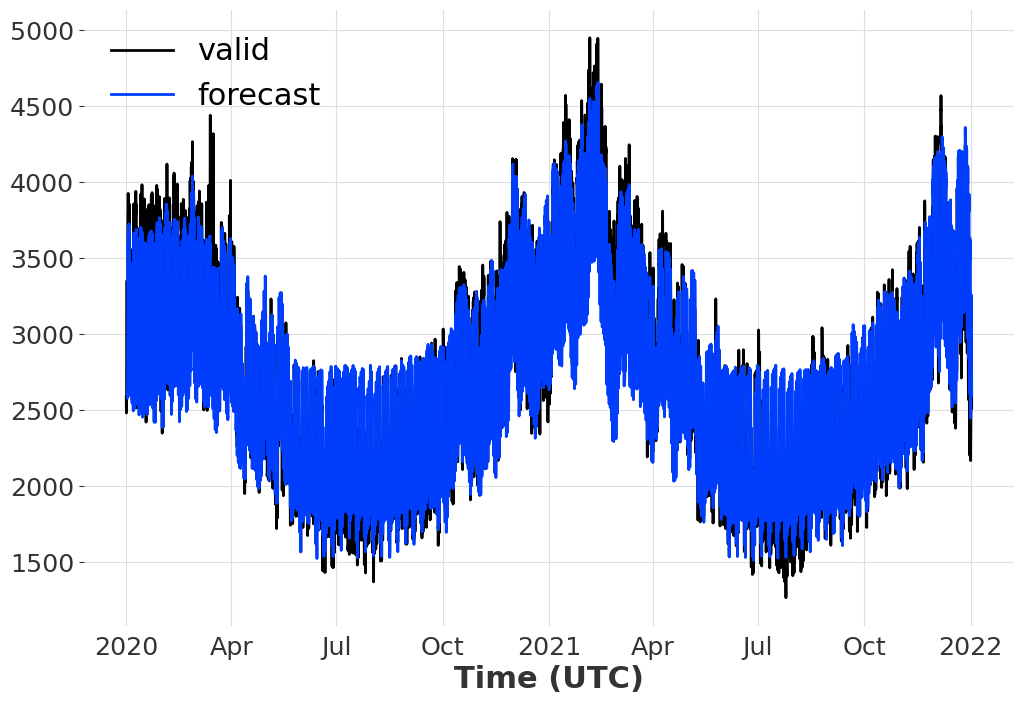

Validation MAPE: 5.00%
Max MAPE: 34.76% on Day 572
Min MAPE: 1.06% on Day 167


In [25]:
# Forecast
forecast = model.predict(n=valid_series.n_timesteps-24, 
                         past_covariates=valid_covariates,
                         future_covariates=valid_covariates)

# Plot results
# train_series.plot(label="train")
valid_series.plot(label="valid")
forecast.plot(label="forecast")

plt.legend()
plt.show()

# Evaluate
error = mape(valid_series, forecast)
print(f"Validation MAPE: {error:.2f}%")

# Break into 24-step chunks
window_size = 24
num_windows = len(forecast) // window_size

# Use numpy to handle splitting of timeseries
actual_np = valid_series.values().flatten()
predicted_np = forecast.values().flatten()

daily_mapes = []

for i in range(num_windows):
    start = i * window_size
    end = start + window_size

    actual_chunk = actual_np[start:end]
    predicted_chunk = predicted_np[start:end]

    daily_error = np.mean(np.abs(actual_chunk - predicted_chunk) / actual_chunk) * 100
    
    daily_mapes.append(daily_error)

max_mape = max(daily_mapes)
min_mape = min(daily_mapes)

max_day = daily_mapes.index(max_mape) + 1  # +1 to make it readable (avoid 0-indexing)
min_day = daily_mapes.index(min_mape) + 1

print(f"Max MAPE: {max_mape:.2f}% on Day {max_day}")
print(f"Min MAPE: {min_mape:.2f}% on Day {min_day}")

C:\Users\andre\AppData\Local\Temp\ipykernel_25760\2917198779.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  predicted_vs_actual = pd.read_csv('processed_loadUTC_data.csv', parse_dates=['Time (UTC)'])


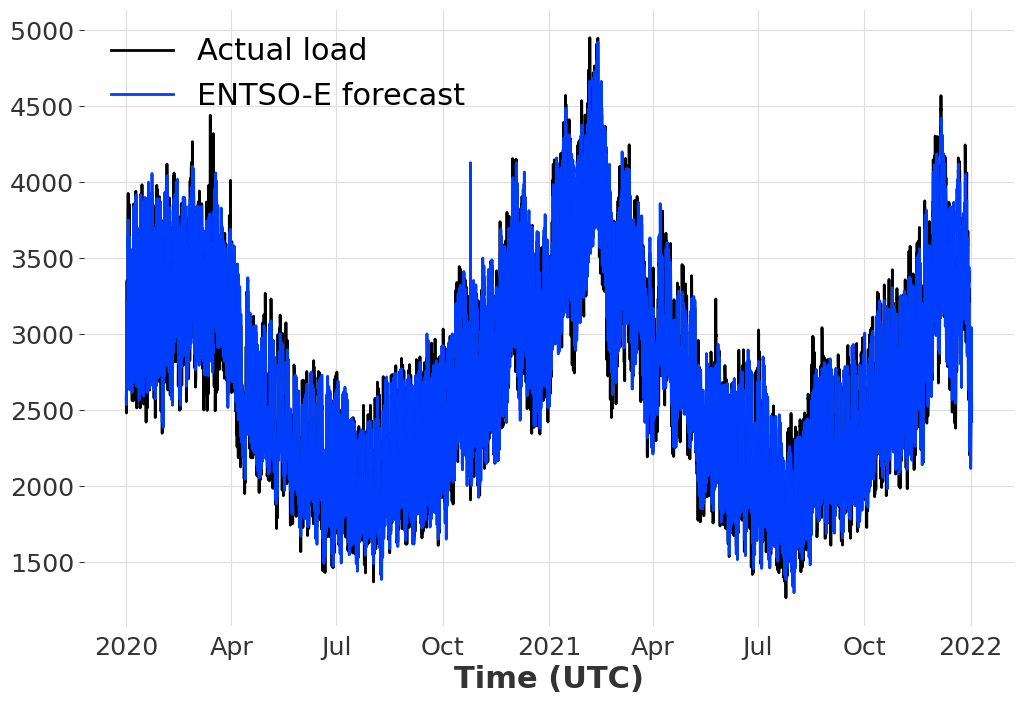

Overall ENTOS-E MAPE: 3.69%
Max MAPE: 29.47% on Day 542
Min MAPE: 0.67% on Day 712


In [37]:
predicted_vs_actual = pd.read_csv('processed_loadUTC_data.csv', parse_dates=['Time (UTC)'])

# Set 'Time (UTC)' as index
predicted_vs_actual['Time (UTC)'] = pd.to_datetime(predicted_vs_actual['Time (UTC)'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
predicted_vs_actual = predicted_vs_actual.set_index('Time (UTC)')

eval_pred_vs_actual = predicted_vs_actual[split_dates[0]:split_dates[1]]

entsoe_actual = TimeSeries.from_dataframe(eval_pred_vs_actual, value_cols="Actual Total Load [MW] - BZN|SE4")
entsoe_forecast = TimeSeries.from_dataframe(eval_pred_vs_actual, value_cols="Day-ahead Total Load Forecast [MW] - BZN|SE4")

# Plot ENSTO-E forecast vs actual load
entsoe_actual.plot(label="Actual load")
entsoe_forecast.plot(label="ENTSO-E forecast")

plt.legend()
plt.show()

entsoe_mape = mape(entsoe_actual, entsoe_forecast)
print(f"Overall ENTOS-E MAPE: {entsoe_mape:.2f}%")

# Break into 24-step chunks
window_size = 24
num_windows = len(forecast) // window_size

# Use numpy to handle splitting of timeseries
actual_np = entsoe_actual.values().flatten()
predicted_np = entsoe_forecast.values().flatten()

daily_mapes = []

for i in range(num_windows):
    start = i * window_size
    end = start + window_size

    actual_chunk = actual_np[start:end]
    predicted_chunk = predicted_np[start:end]

    daily_error = np.mean(np.abs(actual_chunk - predicted_chunk) / actual_chunk) * 100
    
    daily_mapes.append(daily_error)

max_mape = max(daily_mapes)
min_mape = min(daily_mapes)

max_day = daily_mapes.index(max_mape) + 1  # +1 to make it readable (avoid 0-indexing)
min_day = daily_mapes.index(min_mape) + 1

print(f"Max MAPE: {max_mape:.2f}% on Day {max_day}")
print(f"Min MAPE: {min_mape:.2f}% on Day {min_day}")